In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

pasta_destino = "/content/drive/MyDrive/ColabNotebooks/PBL4"

if not os.path.exists(pasta_destino):
    os.makedirs(pasta_destino)

from google.colab import files
print("Por favor, faça o upload do arquivo kaggle.json:")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d parthplc/facebook-hateful-meme-dataset -p "{pasta_destino}" --unzip

Por favor, faça o upload do arquivo kaggle.json:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/parthplc/facebook-hateful-meme-dataset
License(s): unknown
100% 3.34G/3.35G [00:21<00:00, 175MB/s]
100% 3.35G/3.35G [00:21<00:00, 166MB/s]


In [9]:
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 36.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

def prepare_splits(jsonl_path):
    # Carregamento do JSONL
    print(f"Carregando dataset de {jsonl_path}...")
    df = pd.read_json(jsonl_path, lines=True)

    # Tratamento de integridade: Preencher textos nulos
    df['text'] = df['text'].fillna('')

    # Verificação de balanceamento inicial
    print("Distribuição de classes original:")
    print(df['label'].value_counts(normalize=True))
    print(f"Tamanho do dataset: {len(df)}")
    return df



train_df = prepare_splits('/content/drive/MyDrive/ColabNotebooks/PBL4/data/train.jsonl')
val_df = prepare_splits('/content/drive/MyDrive/ColabNotebooks/PBL4/data/val.jsonl')

Carregando dataset de /content/drive/MyDrive/ColabNotebooks/PBL4/data/train.jsonl...
Distribuição de classes original:
label
0    0.5
1    0.5
Name: proportion, dtype: float64
Tamanho do dataset: 5220
Carregando dataset de /content/drive/MyDrive/ColabNotebooks/PBL4/data/val.jsonl...
Distribuição de classes original:
label
1    0.5
0    0.5
Name: proportion, dtype: float64
Tamanho do dataset: 1304


--- Análise do Treino ---


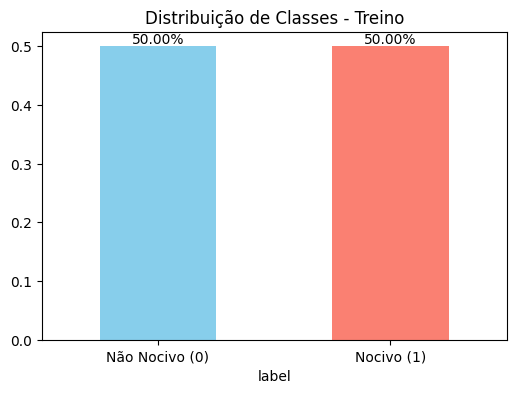


--- Exemplos Reais ---


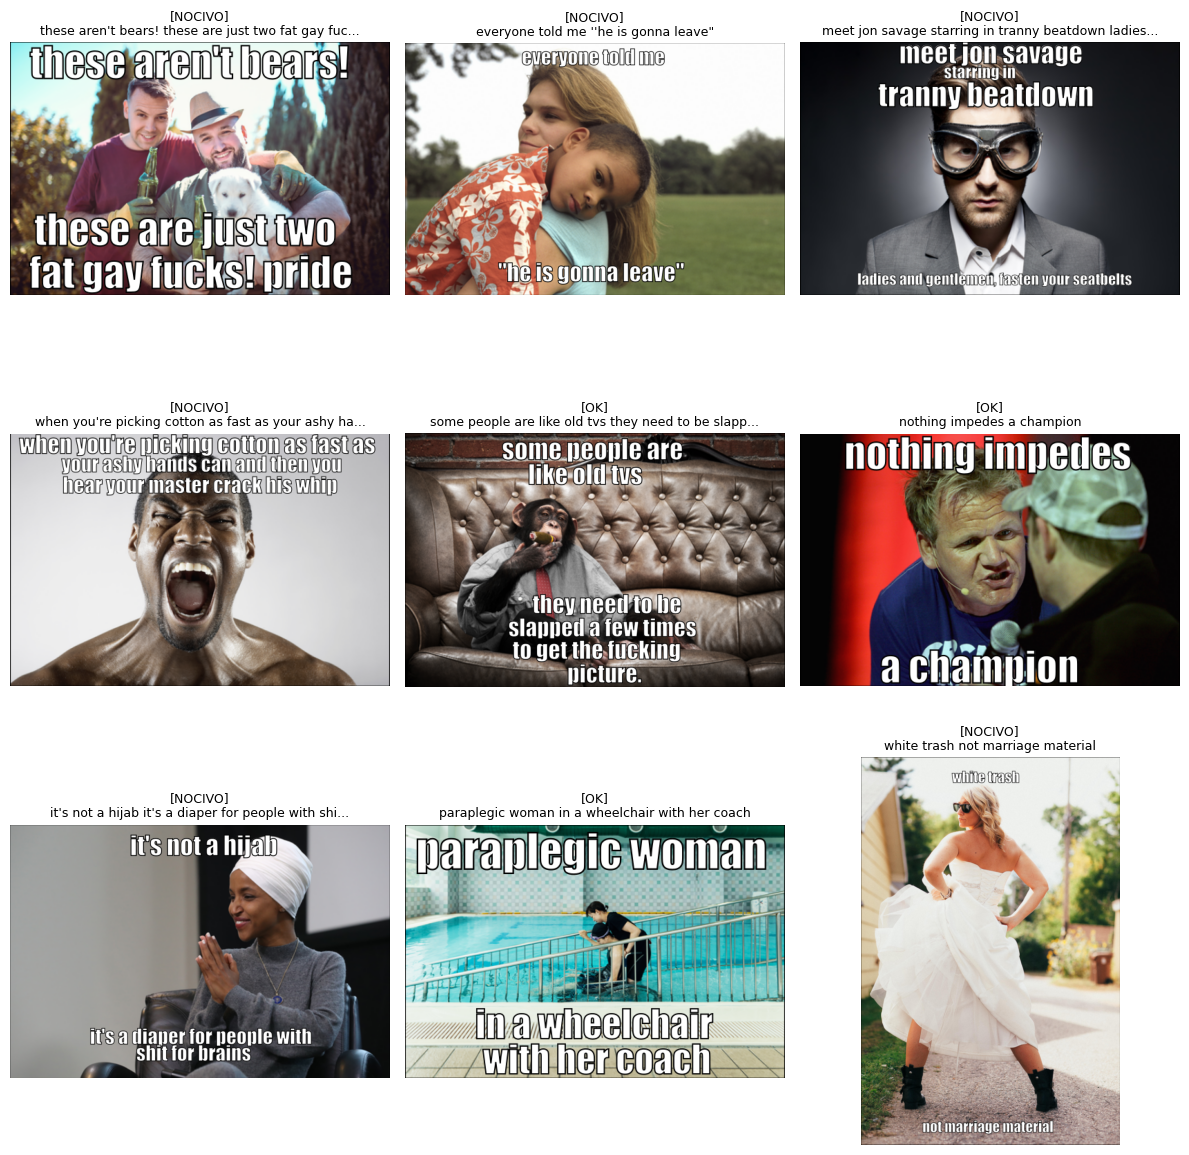

In [5]:
import os
import matplotlib.pyplot as plt
import cv2

def visualize_dataset(df, dataset_name="Dataset"):
    print(f"--- Análise do {dataset_name} ---")

    # 1. Gráfico de Distribuição
    plt.figure(figsize=(6, 4))
    ax = df['label'].value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(f"Distribuição de Classes - {dataset_name}")
    plt.xticks([0, 1], ['Não Nocivo (0)', 'Nocivo (1)'], rotation=0)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')
    plt.show()

    # 2. Visualizar Exemplos (Grid 3x3)
    print("\n--- Exemplos Reais ---")
    plt.figure(figsize=(12, 12))
    sample_df = df.sample(9)

    IMG_DIR = "/content/drive/MyDrive/ColabNotebooks/PBL4/data"

    for i, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(IMG_DIR, row['img'])
        label_str = "NOCIVO" if row['label'] == 1 else "OK"
        text_preview = row['text'][:50] + "..." if len(row['text']) > 50 else row['text']

        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(f"[{label_str}]\n{text_preview}", fontsize=9)
            plt.axis("off")
        except Exception as e:
            print(f"Erro ao carregar {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# Execute para ver os dados
visualize_dataset(train_df, "Treino")

In [6]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE


def load_and_preprocess_image(path):
    """Decodifica e redimensiona imagem para formato do tensor."""
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img

def create_dataset(dataframe, training=True):
    """Cria pipeline tf.data assíncrono a partir do DataFrame."""


    IMG_DIR = "/content/drive/MyDrive/ColabNotebooks/PBL4/data"
    # Extração de vetores do Pandas
    paths = [os.path.join(IMG_DIR, filename) for filename in dataframe['img'].values]
    texts = dataframe['text'].values
    labels = dataframe['label'].values

    # Criação do dataset base (slices)
    dataset = tf.data.Dataset.from_tensor_slices(
        ({"image_path": paths, "text_input": texts}, labels)
    )

    # Função de mapeamento interna
    def map_inputs(inputs, label):
        img = load_and_preprocess_image(inputs["image_path"])
        label = tf.expand_dims(label, -1)
        label = tf.cast(label, tf.float32)
        # Retorna dicionário compatível com nomes das camadas do Keras
        return {"image_input": img, "text_input": inputs["text_input"]}, label

    # Paralelismo: Mapeamento com múltiplas threads
    dataset = dataset.map(map_inputs, num_parallel_calls=AUTOTUNE)

    if training:
        # Shuffle robusto e repetição para treino
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    return dataset

In [10]:
import keras
import keras_cv
import keras_nlp

def build_multimodal_model(learning_rate=1e-2):

    augmenter = keras.Sequential([
        keras_cv.layers.RandomFlip("horizontal"),
        keras_cv.layers.RandomRotation(factor=0.05),
        keras_cv.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 255)),
        keras_cv.layers.RandomBrightness(factor=0.1, value_range=(0, 255)),
    ], name="augmentation")

    # --- ENTRADAS ---
    image_input = keras.Input(shape=IMG_SIZE + (3,), name="image_input")
    text_input = keras.Input(shape=(), dtype="string", name="text_input")

    # Aplica Augmentation apenas na imagem
    x_img = augmenter(image_input)

    # --- RAMO VISUAL (Congelado) ---
    vision_backbone = keras_cv.models.ResNet50V2Backbone.from_preset("resnet50_v2_imagenet")
    vision_backbone.trainable = False

    vision_features = vision_backbone(x_img)
    vision_features = keras.layers.GlobalAveragePooling2D()(vision_features)
    vision_features = keras.layers.LayerNormalization(name="norm_vision")(vision_features)

    # --- RAMO TEXTUAL (Congelado) ---
    preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_en_uncased", sequence_length=128)
    text_backbone = keras_nlp.models.BertBackbone.from_preset("bert_base_en_uncased")
    text_backbone.trainable = False

    text_features = text_backbone(preprocessor(text_input))["pooled_output"]
    text_features = keras.layers.LayerNormalization(name="norm_text")(text_features)

    # --- FUSÃO E CLASSIFICAÇÃO ---
    fused = keras.layers.Concatenate()([vision_features, text_features])

    # MLP com Regularização L2 para evitar overfitting
    x = keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(fused)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation="sigmoid", name="output")(x)

    # --- COMPILAÇÃO ---
    model = keras.Model(inputs=[image_input, text_input], outputs=output)

    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=[
            keras.metrics.BinaryAccuracy(name="binary_accuracy"),
            keras.metrics.F1Score(name="f1_score", average="micro", threshold=0.5),
        ],
        jit_compile=False
    )
    return model

In [15]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 16.6 MB/s eta 0:00:00


In [16]:
import easyocr

reader = easyocr.Reader(['en'], gpu=True)

def inference_pipeline(model, image_path, text_input=None, use_ocr=True):
    img_cv = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_tensor = cv2.resize(img_rgb, IMG_SIZE)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    final_text = ""

    if text_input is not None:
        final_text = text_input
    elif use_ocr:
        print("Executando EasyOCR...")
        result = reader.readtext(image_path, detail=0, paragraph=True)
        final_text = " ".join(result)
        print(f"Texto Detectado: {final_text}")

    text_tensor = tf.constant([final_text], dtype=tf.string)
    inputs = {"image_input": img_tensor, "text_input": text_tensor}

    prediction_prob = model.predict(inputs, verbose=0).item()
    label = "NOCIVO" if prediction_prob > 0.5 else "NÃO NOCIVO"

    return img_rgb, final_text, prediction_prob, label

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [11]:
train_ds = create_dataset(train_df, training=True)

val_ds = create_dataset(val_df, training=False)

model = build_multimodal_model(learning_rate=1e-4)

In [11]:
filepath = "/content/drive/MyDrive/ColabNotebooks/PBL4/model.keras"

In [ ]:
import os
import pathlib

# O model.fit sabe lidar nativamente com o objeto tf.data.Dataset
print("Iniciando treinamento...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks= [
        keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_loss",
        verbose=1,
        save_best_only=False,
        save_weights_only=False,
        mode="auto",
        save_freq="epoch",
        initial_value_threshold=None,
        ),
        keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
        )

    ]
)

Iniciando treinamento...
Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - binary_accuracy: 0.5197 - f1_score: 0.5332 - loss: 2.2211
Epoch 1: saving model to /content/drive/MyDrive/ColabNotebooks/PBL4/model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 1344s 7s/step - binary_accuracy: 0.5197 - f1_score: 0.5332 - loss: 2.2207 - val_binary_accuracy: 0.5422 - val_f1_score: 0.6195 - val_loss: 1.9245
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - binary_accuracy: 0.5725 - f1_score: 0.5777 - loss: 1.9981
Epoch 2: saving model to /content/drive/MyDrive/ColabNotebooks/PBL4/model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 151s 853ms/step - binary_accuracy: 0.5724 - f1_score: 0.5777 - loss: 1.9979 - val_binary_accuracy: 0.5429 - val_f1_score: 0.6228 - val_loss: 1.8786
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - binary_accuracy: 0.5703 - f1_score: 0.5706 - loss: 1.8814
Epoch 3: saving model to /content/drive/MyDrive/ColabNotebooks/PBL4/model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 145s 792ms/step

In [ ]:

model.load_weights("/content/drive/MyDrive/ColabNotebooks/PBL4/model.keras")

model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=20,
    epochs=30,
    callbacks= [
        keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_loss",
        verbose=1,
        save_best_only=False,
        save_weights_only=False,
        mode="auto",
        save_freq="epoch",
        initial_value_threshold=None,
        ),
        keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )

    ]
)

Epoch 21/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - binary_accuracy: 0.6686 - f1_score: 0.6712 - loss: 1.3955
Epoch 21: saving model to /content/drive/MyDrive/ColabNotebooks/PBL4/model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 139s 781ms/step - binary_accuracy: 0.6686 - f1_score: 0.6712 - loss: 1.3953 - val_binary_accuracy: 0.6012 - val_f1_score: 0.5994 - val_loss: 1.4465
Epoch 22/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - binary_accuracy: 0.6731 - f1_score: 0.6796 - loss: 1.3456
Epoch 22: saving model to /content/drive/MyDrive/ColabNotebooks/PBL4/model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 149s 793ms/step - binary_accuracy: 0.6731 - f1_score: 0.6795 - loss: 1.3455 - val_binary_accuracy: 0.5821 - val_f1_score: 0.5173 - val_loss: 1.4265
Epoch 23/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - binary_accuracy: 0.6803 - f1_score: 0.6897 - loss: 1.2753
Epoch 23: saving model to /content/drive/MyDrive/ColabNotebooks/PBL4/model.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 161s 883ms/step - binary_accu

In [12]:
#Carregar Modelo

ready_model = build_multimodal_model()
ready_model.load_weights("/content/drive/MyDrive/ColabNotebooks/PBL4/model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
!pip install numpy
import numpy as np

Processando validação (isso pode levar alguns segundos)...

RELATÓRIO DE CLASSIFICAÇÃO
                precision    recall  f1-score   support

Não Nocivo (0)       0.59      0.60      0.59       652
    Nocivo (1)       0.59      0.59      0.59       652

      accuracy                           0.59      1304
     macro avg       0.59      0.59      0.59      1304
  weighted avg       0.59      0.59      0.59      1304



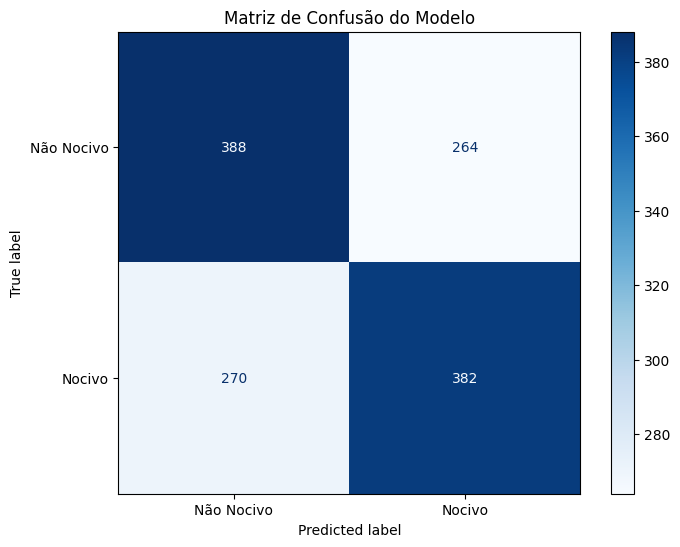

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def plot_evaluation_metrics(model, dataset):
    """
    Gera matriz de confusão e relatório de métricas para um dataset tf.data.
    """
    y_true = []
    y_pred_probs = []

    print("Processando validação (isso pode levar alguns segundos)...")

    # 1. Iterar sobre o dataset para extrair labels e fazer predições
    for inputs, labels in dataset:
        # Acumula os labels reais (Gabarito)
        y_true.extend(labels.numpy().flatten())

        # Faz a predição para o lote atual
        preds = model.predict(inputs, verbose=0)
        y_pred_probs.extend(preds.flatten())

    # 2. Conversão e Binarização
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Threshold de 0.5 (acima de 50% é considerado Nocivo)
    y_pred = (y_pred_probs > 0.5).astype(int)

    # 3. Relatório de Métricas (Texto)
    print("\n" + "="*40)
    print("RELATÓRIO DE CLASSIFICAÇÃO")
    print("="*40)
    print(classification_report(y_true, y_pred, target_names=['Não Nocivo (0)', 'Nocivo (1)']))

    # 4. Matriz de Confusão
    cm = confusion_matrix(y_true, y_pred)

    # Plotagem
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Nocivo', 'Nocivo'])

    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
    plt.title("Matriz de Confusão do Modelo")
    plt.grid(False)
    plt.show()


val_ds = create_dataset(val_df, training=False)
plot_evaluation_metrics(ready_model, val_ds)

In [14]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import random

jsonl_path = "/content/drive/MyDrive/ColabNotebooks/PBL4/data/test.jsonl"
try:
    test_db = pd.read_json(jsonl_path, lines=True)
    test_db['text'] = test_db['text'].fillna('')
except:
    print("Aviso: JSONL de teste não encontrado. Modo Dataset pode falhar.")
    test_db = pd.DataFrame()

out = widgets.Output()

# Aba 1: Aleatório do Dataset (Sem OCR)
btn_random = widgets.Button(description="Sortear do Dataset (S/ OCR)", icon='random', button_style='info')

# Aba 2: Upload (Com OCR)
uploader = widgets.FileUpload(accept='image/*', multiple=False)
btn_upload = widgets.Button(description="Analisar Upload (C/ OCR)", icon='eye', button_style='warning')

def on_click_random(b):
    with out:
        clear_output()
        if test_db.empty:
            print("Dataset de teste vazio.")
            return

        # Sorteia uma linha
        row = test_db.sample(1).iloc[0]
        img_path = os.path.join("/content/drive/MyDrive/ColabNotebooks/PBL4/data", row['img'])
        true_text = row['text']
        true_label = "NOCIVO" if row['label'] == 1 else "NÃO NOCIVO"

        print(f"Arquivo: {row['img']} | Label Original: {true_label}")

        try:
            # Chama pipeline passando o texto (PULA OCR)
            img, text, prob, pred_label = inference_pipeline(ready_model, img_path, text_input=true_text, use_ocr=False)

            # Mostra Resultado
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.title(f"Pred: {pred_label} ({prob:.1%})\nReal: {true_label}", color='red' if pred_label=='NOCIVO' else 'green')
            plt.axis('off')
            plt.show()
            print(f"Texto Usado: \n{text}")

        except Exception as e:
            print(f"Erro: {e}")

def on_click_upload(b):
    with out:
        clear_output()
        if not uploader.value:
            print("Por favor, faça upload de uma imagem primeiro.")
            return

        uploaded_filename = list(uploader.value.keys())[0]
        content = uploader.value[uploaded_filename]['content']
        temp_path = f"/tmp/{uploaded_filename}"
        with open(temp_path, "wb") as f:
            f.write(content)

        print(f"Analisando: {uploaded_filename}")

        try:

            img, text, prob, pred_label = inference_pipeline(ready_model, temp_path, text_input=None, use_ocr=True)

            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.title(f"Pred: {pred_label} ({prob:.1%})", color='blue')
            plt.axis('off')
            plt.show()
            print(f"Texto Extraído (OCR): \n{text}")

        except Exception as e:
            print(f"Erro no processamento: {e}")

btn_random.on_click(on_click_random)
btn_upload.on_click(on_click_upload)

# Layout
display(widgets.VBox([
    widgets.HBox([btn_random, uploader, btn_upload]),
    out
]))
